In [1]:
import json 
import pyspark as ps
import numpy as np

In [2]:
!head data/churn/upsell.data

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


In [3]:
!head data/churn/orange_small_train.data

In [4]:
!wc -l data/churn/orange_small_train.data

   50001 data/churn/orange_small_train.data


In [5]:
sc = ps.SparkContext()

In [6]:
churn_rdd = sc.textFile('file:///Users/jonathandinu/spark-ds-applications/data/churn/small_combined.tsv')

In [7]:
header = churn_rdd.first()

# first 190 numeric, last 40 categorical
churn_rows = churn_rdd.filter(lambda x: x != header).map(lambda x: x.split('\t')[:190])

In [8]:
churn_rows.first()

[u'-1',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'1526',
 u'7',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'184',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'464',
 u'580',
 u'',
 u'14',
 u'128',
 u'',
 u'',
 u'166.56',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'0',
 u'',
 u'',
 u'3570',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'0',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'4.076907',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'9',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'36',
 u'35',
 u'',
 u'1350864',
 u'',
 u'0',
 u'',
 u'',
 u'7333.11',
 u'',
 u'5',
 u'',
 u'12',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'104',
 u'',
 u'',
 u'168',
 u'117625.6',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'1175',
 u'',
 u'',
 u'',
 u'6',
 u'',
 u'720',
 u'8',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'0',
 u'1212385',
 u'69134',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'185',
 u'',
 u'',
 u'0',
 u'9',
 u'',
 u'',
 u'',
 u'',
 

## Preprocessing
* convert types
* filter out null columns
* imputing missing values

In [9]:
rdd_typed = churn_rows.map(lambda row: dict(zip(header.split('\t')[:190], \
                                                           map(lambda x: None if x == '' else float(x), row))))

In [10]:
rdd_typed.first()

{u'Var1': None,
 u'Var10': None,
 u'Var100': None,
 u'Var101': None,
 u'Var102': None,
 u'Var103': None,
 u'Var104': None,
 u'Var105': None,
 u'Var106': None,
 u'Var107': None,
 u'Var108': None,
 u'Var109': 104.0,
 u'Var11': None,
 u'Var110': None,
 u'Var111': None,
 u'Var112': 168.0,
 u'Var113': 117625.6,
 u'Var114': None,
 u'Var115': None,
 u'Var116': None,
 u'Var117': None,
 u'Var118': None,
 u'Var119': 1175.0,
 u'Var12': None,
 u'Var120': None,
 u'Var121': None,
 u'Var122': None,
 u'Var123': 6.0,
 u'Var124': None,
 u'Var125': 720.0,
 u'Var126': 8.0,
 u'Var127': None,
 u'Var128': None,
 u'Var129': None,
 u'Var13': 184.0,
 u'Var130': None,
 u'Var131': None,
 u'Var132': 0.0,
 u'Var133': 1212385.0,
 u'Var134': 69134.0,
 u'Var135': None,
 u'Var136': None,
 u'Var137': None,
 u'Var138': None,
 u'Var139': None,
 u'Var14': None,
 u'Var140': 185.0,
 u'Var141': None,
 u'Var142': None,
 u'Var143': 0.0,
 u'Var144': 9.0,
 u'Var145': None,
 u'Var146': None,
 u'Var147': None,
 u'Var148': None,
 u'

In [11]:
from collections import Counter

class CounterAccumulatorParam(ps.accumulators.AccumulatorParam):
    def zero(self, initialValue):
        return Counter()

    def addInPlace(self, v1, v2):
        v1 += v2
        return v1

accum = sc.accumulator(Counter(), CounterAccumulatorParam())

def count_null(record):
    global accum
    
    c = Counter()
    
    for key, value in record.items():
            # since columns are initially strings
            # empty string signals missing value
            if value == None:
                c[key] += 1
                
    accum.add(c)

In [12]:
rdd_typed.foreach(count_null)

In [13]:
accum.value

Counter({u'Var20': 50000, u'Var185': 50000, u'Var52': 50000, u'Var55': 50000, u'Var48': 50000, u'Var42': 50000, u'Var141': 50000, u'Var79': 50000, u'Var8': 50000, u'Var15': 50000, u'Var167': 50000, u'Var169': 50000, u'Var32': 50000, u'Var31': 50000, u'Var39': 50000, u'Var175': 50000, u'Var118': 49829, u'Var92': 49829, u'Var64': 49762, u'Var45': 49656, u'Var102': 49549, u'Var62': 49442, u'Var98': 49442, u'Var12': 49442, u'Var56': 49354, u'Var89': 49354, u'Var178': 49354, u'Var136': 49306, u'Var63': 49306, u'Var66': 49306, u'Var156': 49306, u'Var116': 49298, u'Var110': 49298, u'Var29': 49298, u'Var186': 49298, u'Var187': 49298, u'Var180': 49298, u'Var121': 49298, u'Var129': 49298, u'Var58': 49298, u'Var50': 49298, u'Var53': 49298, u'Var137': 49298, u'Var131': 49298, u'Var41': 49298, u'Var47': 49298, u'Var77': 49298, u'Var142': 49298, u'Var154': 49298, u'Var1': 49298, u'Var9': 49298, u'Var90': 49298, u'Var86': 49298, u'Var87': 49298, u'Var168': 49298, u'Var100': 49298, u'Var108': 49298, u

In [14]:
columns_to_drop = [ k for k, v in accum.value.items() if v > 15000]

In [15]:
columns_to_keep = set(header.split('\t')[:190]) - set(columns_to_drop)

In [16]:
len(columns_to_keep)

40

In [17]:
from pyspark.sql.types import *

sqlContext = ps.HiveContext(sc)

In [18]:
df = sqlContext.jsonRDD(rdd_typed.map(lambda row: json.dumps(row)))

In [19]:
df.printSchema()

root
 |-- Var1: double (nullable = true)
 |-- Var10: double (nullable = true)
 |-- Var100: double (nullable = true)
 |-- Var101: double (nullable = true)
 |-- Var102: double (nullable = true)
 |-- Var103: double (nullable = true)
 |-- Var104: double (nullable = true)
 |-- Var105: double (nullable = true)
 |-- Var106: double (nullable = true)
 |-- Var107: double (nullable = true)
 |-- Var108: double (nullable = true)
 |-- Var109: double (nullable = true)
 |-- Var11: double (nullable = true)
 |-- Var110: double (nullable = true)
 |-- Var111: double (nullable = true)
 |-- Var112: double (nullable = true)
 |-- Var113: double (nullable = true)
 |-- Var114: double (nullable = true)
 |-- Var115: double (nullable = true)
 |-- Var116: double (nullable = true)
 |-- Var117: double (nullable = true)
 |-- Var118: double (nullable = true)
 |-- Var119: double (nullable = true)
 |-- Var12: double (nullable = true)
 |-- Var120: double (nullable = true)
 |-- Var121: double (nullable = true)
 |-- Var122:

In [20]:
df_subset = df.select(list(columns_to_keep))

In [21]:
df_subset.show()

+-----+---------+------+----------+---------+---------+------+--------+------+-----+------+-----+-----+---------+------+-----+----+------+-----+-----+------+------+------+-----+------+---------+---------+-----+-------+------+------+-------+---------+------+-----+------+------+---------+-----+------+
|Var65|   Var113|Var112|    Var153|   Var134|   Var133|Var132|   Var81|Var123|Var74| Var28|Var24|Var25|    Var38| Var21|Var44|Var7|  Var6|Var83|label|Var160| Var22|Var143|Var35|Var181|    Var76|   Var149|Var73| Var125|Var126|Var119| Var140|   Var163|Var144|Var78| Var13|Var109|    Var57|Var85|Var173|
+-----+---------+------+----------+---------+---------+------+--------+------+-----+------+-----+-----+---------+------+-----+----+------+-----+-----+------+------+------+-----+------+---------+---------+-----+-------+------+------+-------+---------+------+-----+------+------+---------+-----+------+
|  9.0| 117625.6| 168.0| 1812252.0|  69134.0|1212385.0|   0.0| 7333.11|   6.0| 35.0|166.56| 14.0|

In [22]:
df_subset.count()

50000

In [23]:
df_subset.dropna().count()

29675

In [24]:
summary = df_subset.describe()
summary.show()

+-------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+--------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|summary|             Var65|             Var113|            Var112|           Var153|           Var134|            Var133|            Var132|             Var81|          Var123|             Var74|            Var28|            Var24|        

In [25]:
means_df = summary.toPandas().set_index('summary').loc['mean']

In [26]:
means_df

Var65        14.868896336114798
Var113      -153278.60848674004
Var112        66.22106643550933
Var153        6181967.170056233
Var134        437340.3848769754
Var133       2273571.9194950103
Var132       3.5246160343179747
Var81        103084.05269283189
Var123         60.1880376075215
Var74        103.65812734756304
Var28         224.5076691635697
Var24         4.507926116436755
Var25         96.82700984641373
Var38         2579106.927518837
Var21         234.5182253603472
Var44       0.16683336667333468
Var7          6.809495962753874
Var6          1326.437116322997
Var83        20.023560267609078
label                  -0.85272
Var160        38.80300504545354
Var22         290.2453824098153
Var143     0.058011602320464095
Var35        0.7168100286724012
Var181        0.611455624458225
Var76        1490153.8366339935
Var149        294920.8042553192
Var73                  66.64108
Var125        27887.62517712152
Var126       -0.553880266075388
Var119        916.1121854691821
Var140  

In [27]:
imputed = df_subset.na.fill(dict(means_df.apply(float)))

In [28]:
imputed.take(5)

[Row(Var65=9.0, Var113=117625.6, Var112=168.0, Var153=1812252.0, Var134=69134.0, Var133=1212385.0, Var132=0.0, Var81=7333.11, Var123=6.0, Var74=35.0, Var28=166.56, Var24=14.0, Var25=128.0, Var38=3570.0, Var21=464.0, Var44=0.0, Var7=7.0, Var6=1526.0, Var83=5.0, label=-1.0, Var160=142.0, Var22=580.0, Var143=0.0, Var35=0.0, Var181=0.0, Var76=1350864.0, Var149=397579.0, Var73=36.0, Var125=720.0, Var126=8.0, Var119=1175.0, Var140=185.0, Var163=38418.0, Var144=9.0, Var78=0.0, Var13=184.0, Var109=104.0, Var57=4.076907, Var85=12.0, Var173=0.0),
 Row(Var65=9.0, Var113=-356411.6, Var112=40.0, Var153=10439160.0, Var134=357038.0, Var133=4136430.0, Var132=8.0, Var81=151098.9, Var123=72.0, Var74=0.0, Var28=353.52, Var24=2.0, Var25=24.0, Var38=4764966.0, Var21=168.0, Var44=0.0, Var7=0.0, Var6=525.0, Var83=25.0, label=-1.0, Var160=32.0, Var22=210.0, Var143=0.0, Var35=0.0, Var181=0.0, Var76=2872928.0, Var149=278334.0, Var73=26.0, Var125=0.0, Var126=-0.553880266075, Var119=590.0, Var140=0.0, Var163=2385

## Convert to MLlib Datatypes
* MLlib: LabeledPoint
* `spark.ml`: Dataframe

In [29]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

def create_points(row):
    label = 0.0 if row.label == -1.0 else 1.0
    
    f_dict = row.asDict()
    f_dict.pop('label')
    
    # make sure the features are in the same order for each data point
    features = [ x[1] for x in sorted(f_dict.items())]
    
    return LabeledPoint(label, Vectors.dense(features))

In [30]:
feature_rdd = imputed.rdd.map(create_points)

In [31]:
feature_rdd.first()

LabeledPoint(0.0, [104.0,168.0,117625.6,1175.0,6.0,720.0,8.0,184.0,0.0,1212385.0,69134.0,185.0,0.0,9.0,397579.0,1812252.0,142.0,38418.0,0.0,0.0,464.0,580.0,14.0,128.0,166.56,0.0,3570.0,0.0,4.076907,1526.0,9.0,7.0,36.0,35.0,1350864.0,0.0,7333.11,5.0,12.0])

## Building a Model with MLlib

* test/train split
* preprocessing of features
* training
* evaluation

In [32]:
(train_set, test_set) = feature_rdd.randomSplit([0.8, 0.2])

In [33]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

In [34]:
lrmodel = LogisticRegressionWithLBFGS.train(train_set)

In [35]:
type(lrmodel)

pyspark.mllib.classification.LogisticRegressionModel

In [36]:
predictions = lrmodel.predict(test_set.map(lambda x: x.features))

In [37]:
scores_and_labels = predictions.zip(test_set.map(lambda x: x.label))

In [38]:
test_err = scores_and_labels.filter(lambda (p, v): v != p).count() / float(test_set.count())

In [39]:
print 'Test Error = ' + str(test_err)
print "Accuracy: " + str((1.0 - test_err) * 100)

Test Error = 0.0773821364631
Accuracy: 92.2617863537


In [40]:
train_set.groupBy(lambda x: x.label).mapValues(lambda x: len(x)).collect()

[(0.0, 37039), (1.0, 2907)]

In [41]:
2971 / float(37117)

0.08004418460543686

## Model Evaluation

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [43]:
lrmodel

(weights=[-0.000573440103321,0.00027153527539,4.92166700961e-07,-1.36340753014e-05,-1.39969569402e-05,6.00025392036e-08,-0.0337561753727,1.91601306692e-05,-0.00607055384322,-2.06055116386e-08,-1.17046708854e-07,3.44943501257e-06,0.0649222835728,-0.013043144626,8.95194586702e-09,-1.76131602215e-08,-0.000417265358534,1.75779617913e-08,-0.0170142459708,-0.00724631433367,-0.000120079496378,1.23462912376e-05,-0.00391320810314,0.000401922811545,-0.00756802113985,-0.00447888246675,-2.51604738882e-08,-0.0138202890335,-0.0737179786081,1.26566495678e-05,-0.0123837204647,0.00712275822164,5.52724788092e-05,-1.03466870528e-05,-3.21265041211e-10,-0.0405041875314,-2.09495720522e-06,-0.000291517490204,0.00270145995009], intercept=0.0)

In [44]:
lrmodel.weights

DenseVector([-0.0006, 0.0003, 0.0, -0.0, -0.0, 0.0, -0.0338, 0.0, -0.0061, -0.0, -0.0, 0.0, 0.0649, -0.013, 0.0, -0.0, -0.0004, 0.0, -0.017, -0.0072, -0.0001, 0.0, -0.0039, 0.0004, -0.0076, -0.0045, -0.0, -0.0138, -0.0737, 0.0, -0.0124, 0.0071, 0.0001, -0.0, -0.0, -0.0405, -0.0, -0.0003, 0.0027])

In [45]:
lrmodel.threshold

0.5

In [46]:
lrmodel.clearThreshold()

In [47]:
lrmodel.threshold

In [48]:
lrmodel.predict(test_set.map(lambda x: x.features)).collect()

[0.10774174679968923,
 0.016218991336040673,
 0.17232673929508993,
 0.03424143184711809,
 0.054548622927502545,
 0.11734345322199889,
 0.17445255382820501,
 0.14780086614278903,
 0.007416738229005967,
 0.10117309228908833,
 0.11759976552394834,
 0.02582705714409853,
 0.06619832419496444,
 0.046096400771087384,
 0.07083667481349189,
 0.025904529026136262,
 0.0012388046748188842,
 0.031840136253872976,
 0.07576045988901611,
 0.03228555447848915,
 0.020023342514966836,
 0.4480777460713189,
 0.033565510362292425,
 0.23925237838264596,
 0.03612354173176688,
 0.04291898113781928,
 0.0867459874610687,
 0.1401031995735476,
 0.07178901777913832,
 0.03993625642555073,
 0.043310912708890544,
 0.01477579841467171,
 0.10609560299163331,
 0.01471823969371571,
 0.06806511637169647,
 0.022489020043764435,
 0.06467074000133816,
 0.04327131879761095,
 0.07413271362708809,
 0.30545182748087224,
 0.0703230942278116,
 0.060607788564793416,
 0.2946017697800426,
 0.0062540803388741115,
 0.03121353660102567,


In [52]:
y_true = np.array(scores_and_labels.map(lambda lp: lp[1]).collect())
y_pred = np.array(scores_and_labels.map(lambda lp: lp[0]).collect())

In [53]:
test_err = (y_true != y_pred).sum() / float(len(y_pred))
    
print 'Test Error = ' + str(test_err)
print "Accuracy: " + str((1.0 - test_err) * 100)
print "\n"

Test Error = 0.0773821364631
Accuracy: 92.2617863537




In [54]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['no upsell', 'upsell'], rotation=45)
    plt.yticks(tick_marks, ['no upsell', 'upsell'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, Logistic Regression
[[9274    5]
 [ 773    2]]


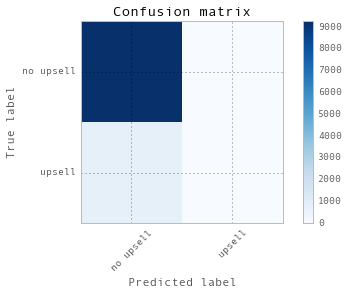

In [55]:
cm = confusion_matrix(y_true,y_pred)
print('Confusion matrix, Logistic Regression')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [56]:
feature_rdd.groupBy(lambda x: x.label).mapValues(lambda x: len(x)).collect()

[(0.0, 46318), (1.0, 3682)]

In [57]:
downsample = feature_rdd.filter(lambda x: x.label != 1.0).sample(False, 0.15)
downsample.count()

6992

In [59]:
balanced_classes = downsample.union(feature_rdd.filter(lambda x: x.label == 1.0))

In [60]:
balanced_classes.groupBy(lambda x: x.label).mapValues(lambda x: len(x)).collect()

[(0.0, 6992), (1.0, 3682)]

In [61]:
(train_set, test_set) = balanced_classes.randomSplit([0.8, 0.2])

In [62]:
lrmodel = LogisticRegressionWithLBFGS.train(train_set)
predictions = lrmodel.predict(test_set.map(lambda x: x.features))
scores_and_labels = predictions.zip(test_set.map(lambda x: x.label))

In [63]:
def evaluate(y_true, y_pred, model):
    test_err = (y_true != y_pred).sum() / float(len(y_pred))
    
    print 'Test Error = ' + str(test_err)
    print "Accuracy: " + str((1.0 - test_err) * 100)
    print "\n"
    
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix ' + model)
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm)

Test Error = 0.287729196051
Accuracy: 71.2270803949


Confusion matrix Logistic Regression
[[1242  134]
 [ 478  273]]


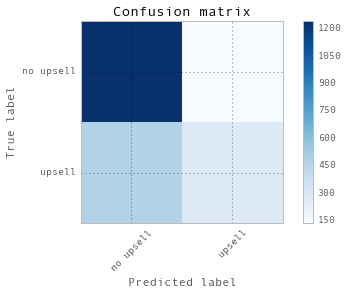

In [64]:
y_true = np.array(scores_and_labels.map(lambda lp: lp[1]).collect())
y_pred = np.array(scores_and_labels.map(lambda lp: lp[0]).collect())
    
evaluate(y_true, y_pred, "Logistic Regression")

## `spark.ml`

In [65]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, VectorIndexer

In [75]:
# lrmodel = LogisticRegressionWithLBFGS.train(train_set)
rf = RandomForestClassifier(featuresCol="features", labelCol="indexed")

In [68]:
type(rf)

pyspark.ml.classification.RandomForestClassifier

In [72]:
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
si_model = stringIndexer.fit(train_set.toDF())
index_df = si_model.transform(train_set.toDF())

In [73]:
index_df.show()

+--------------------+-----+-------+
|            features|label|indexed|
+--------------------+-----+-------+
|[56.0,32.0,-4831....|  0.0|    0.0|
|[60.8886602759,0....|  0.0|    0.0|
|[56.0,72.0,132687...|  0.0|    0.0|
|[136.0,208.0,-157...|  0.0|    0.0|
|[32.0,64.0,73289....|  0.0|    0.0|
|[48.0,32.0,145049...|  0.0|    0.0|
|[32.0,72.0,28480....|  0.0|    0.0|
|[40.0,16.0,51529....|  0.0|    0.0|
|[32.0,8.0,90504.0...|  0.0|    0.0|
|[60.8886602759,66...|  0.0|    0.0|
|[40.0,40.0,68819....|  0.0|    0.0|
|[32.0,40.0,233151...|  0.0|    0.0|
|[96.0,48.0,-12529...|  0.0|    0.0|
|[120.0,120.0,1065...|  0.0|    0.0|
|[48.0,96.0,-96118...|  0.0|    0.0|
|[32.0,56.0,109776...|  0.0|    0.0|
|[24.0,40.0,-55352...|  0.0|    0.0|
|[72.0,56.0,296858...|  0.0|    0.0|
|[48.0,56.0,-50004...|  0.0|    0.0|
|[60.8886602759,66...|  0.0|    0.0|
+--------------------+-----+-------+



In [76]:
rf_model = rf.fit(index_df)

In [77]:
predictions = rf_model.transform(test_set.toDF())

In [78]:
predictions.show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[24.0,24.0,-35327...|  0.0|       0.0|
|[0.0,0.0,-2526.71...|  0.0|       0.0|
|[64.0,56.0,350274...|  0.0|       0.0|
|[60.8886602759,0....|  0.0|       0.0|
|[32.0,32.0,113571...|  0.0|       0.0|
|[60.8886602759,0....|  0.0|       0.0|
|[60.8886602759,0....|  0.0|       0.0|
|[32.0,16.0,83453....|  0.0|       0.0|
|[16.0,0.0,75306.4...|  0.0|       0.0|
|[40.0,32.0,318276...|  0.0|       0.0|
|[60.8886602759,0....|  0.0|       0.0|
|[8.0,0.0,153616.0...|  0.0|       0.0|
|[40.0,56.0,36570....|  0.0|       0.0|
|[32.0,48.0,941976...|  0.0|       0.0|
|[60.8886602759,66...|  0.0|       0.0|
|[60.8886602759,66...|  0.0|       0.0|
|[40.0,32.0,-15022...|  0.0|       0.0|
|[80.0,104.0,-2040...|  0.0|       0.0|
|[24.0,104.0,15944...|  0.0|       0.0|
|[40.0,24.0,294188...|  0.0|       0.0|
+--------------------+-----+----------+



             precision    recall  f1-score   support

        0.0       0.76      0.99      0.86      1376
        1.0       0.94      0.42      0.59       751

avg / total       0.82      0.79      0.76      2127

Test Error = 0.212505876822
Accuracy: 78.7494123178


Confusion matrix Random Forest
[[1356   20]
 [ 432  319]]


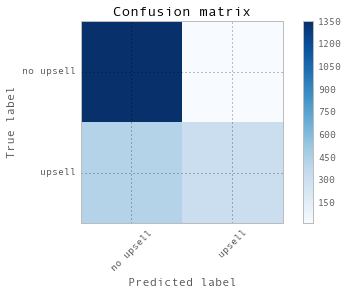

In [79]:
y_true = np.array(predictions.map(lambda x: x.label).collect())
y_pred = np.array(predictions.map(lambda x: x.prediction).collect())

print classification_report(y_true, y_pred)
evaluate(y_true, y_pred, "Random Forest")

## Pipelines

In [81]:
# scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(train_set.toDF())

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(train_set.toDF())

In [82]:
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
si_model = stringIndexer.fit(scaledData)
index_df = si_model.transform(scaledData)

In [96]:
gbt = GBTClassifier(labelCol="indexed", featuresCol='scaledFeatures', maxIter=100)

In [84]:
model = gbt.fit(index_df)

In [85]:
predictions = model.transform(scalerModel.transform(test_set.toDF()))

In [86]:
from pyspark.ml import Pipeline

In [97]:
pipelineGBT = Pipeline(stages=[scaler, stringIndexer, gbt])

In [90]:
pipelineGBT.stages

Param(parent='Pipeline_4f90ad0fe7376688a9fb', name='stages', doc='pipeline stages')

In [98]:
gbt_model = pipelineGBT.fit(train_set.toDF())

In [99]:
predictions = gbt_model.transform(test_set.toDF())

In [93]:
predictions.show()

+--------------------+-----+--------------------+-------+----------+
|            features|label|      scaledFeatures|indexed|prediction|
+--------------------+-----+--------------------+-------+----------+
|[24.0,24.0,-35327...|  0.0|[-0.2841872064726...|    0.0|       0.0|
|[0.0,0.0,-2526.71...|  0.0|[-0.4557386866640...|    0.0|       0.0|
|[64.0,56.0,350274...|  0.0|[0.00173192717971...|    0.0|       0.0|
|[60.8886602759,0....|  0.0|[-0.0205078617806...|    0.0|       0.0|
|[32.0,32.0,113571...|  0.0|[-0.2270033797421...|    0.0|       0.0|
|[60.8886602759,0....|  0.0|[-0.0205078617806...|    0.0|       0.0|
|[60.8886602759,0....|  0.0|[-0.0205078617806...|    0.0|       0.0|
|[32.0,16.0,83453....|  0.0|[-0.2270033797421...|    0.0|       0.0|
|[16.0,0.0,75306.4...|  0.0|[-0.3413710332030...|    0.0|       0.0|
|[40.0,32.0,318276...|  0.0|[-0.1698195530116...|    0.0|       0.0|
|[60.8886602759,0....|  0.0|[-0.0205078617806...|    0.0|       0.0|
|[8.0,0.0,153616.0...|  0.0|[-0.39

In [94]:
gbt_model.stages

[StandardScaler_4d6bb47b72f3943d3a86,
 StringIndexer_4644863e7bea8b848f5c,
 GBTClassifier_4a28808bf252ef21c40c]

             precision    recall  f1-score   support

        0.0       0.77      0.97      0.86      1376
        1.0       0.90      0.46      0.61       751

avg / total       0.81      0.79      0.77      2127

Test Error = 0.208274565115
Accuracy: 79.1725434885


Confusion matrix GBT, Pipeline
[[1336   40]
 [ 403  348]]


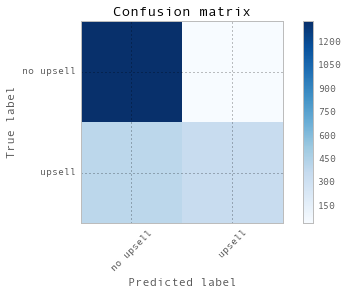

In [95]:
y_true = np.array(predictions.map(lambda x: x.label).collect())
y_pred = np.array(predictions.map(lambda x: x.prediction).collect())

print classification_report(y_true, y_pred)
evaluate(y_true, y_pred, "GBT, Pipeline")

             precision    recall  f1-score   support

        0.0       0.77      0.95      0.85      1376
        1.0       0.84      0.49      0.62       751

avg / total       0.80      0.79      0.77      2127

Test Error = 0.212505876822
Accuracy: 78.7494123178


Confusion matrix GBT, Pipeline (100 iterations)
[[1305   71]
 [ 381  370]]


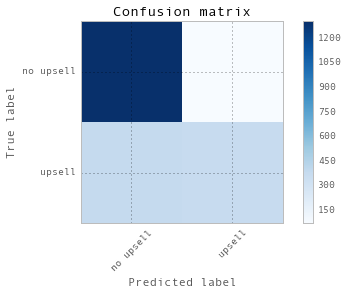

In [100]:
y_true = np.array(predictions.map(lambda x: x.label).collect())
y_pred = np.array(predictions.map(lambda x: x.prediction).collect())

print classification_report(y_true, y_pred)
evaluate(y_true, y_pred, "GBT, Pipeline (100 iterations)")